## 1-D Transiet heat diffusion solver with Physics Informed Neural Networks 

**Import the libraries**

In [2]:
## Import basic numerical and plotting packages ##
from utils.importer import *

## Import the numerical PDE solver ##
from utils.numericalSolver import NumPDE

# ## Import the neural network dataprocessor and framework ##
from utils.dataNN import DataPreprocessor, PINN

**Setup the calculation details**

The governing equation is by, 

$$\frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2}$$  

The domain and time range is defined as follows, 

$$\forall \, x \in (0,l) \text{ and } 0 < t < t_{range}$$

Initial conditions are as follows,

$$T(x, 0) = 0 $$

Boundary conditions are defined as,

$$ \left.\frac{\partial T}{\partial x}\right\vert_{(0,t)} = 0 \text{ and } \left. T \right\vert_{(l,t)} = sin(t)$$

In [4]:
## total time of simulation and length of the system ##
trange, l = 2*np.pi, 1

## Package the time and spatial domain ##
extent = [[0, l], [0, trange]]

## Specify time and space discretizations ##
nx, nt = 256, 100

## Specify how much of available training data will be randomly picked for training in the domain, IC and BCs##
frac = {'ic': 0.8, 'bc': 0.8, 'dom' : 0.4}

## Specify the number of random points in the domain to evaluate PDE loss
N_f = 10000

## Neural Network structure ##
    ## Two inputs (x and t) and one output (temperature)
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

## Initialize the 1-D grid for the numerical solver ##
grid = CartesianGrid([[0, l]], nx)  

## Setup the initial condition of the system ##
    ## For the current problem it is set at 0 ##
field = ScalarField(grid, 0)        

## Definition of the diffusion PDE ##
    ## Specify diffusivity of the domain ##
diffusivity = 0.1
    ## Define the rhs of differential equation ##
rhs = f"(({diffusivity}) * laplace(c))"
    ## Specify the boundary conditions, first left end and then right end ##
bc = [[{'derivative':0}, {'value_expression':'sin(t)'}]]
    ## package thegoverning equation and boundary conditions ##
eq = PDE({"c": f"{rhs}"}, bc=bc)

**Obtain the numerical solution**

In [5]:
## Obtain the numerical solution ##
    ## We use explicit RK-4 adaptive time stepping ##
    ## Also specified the time discretization  using the variable nt ##
if os.path.isfile('saved/numSol.pkl'):
    with open('saved/numSol.pkl', 'rb') as file:
        numSol = pkl.load(file)
else:
    numSol = NumPDE(eq, grid, field, 'Explicit', trange, trange/nt).ground_truth

**Create the NN data from numerical solution**

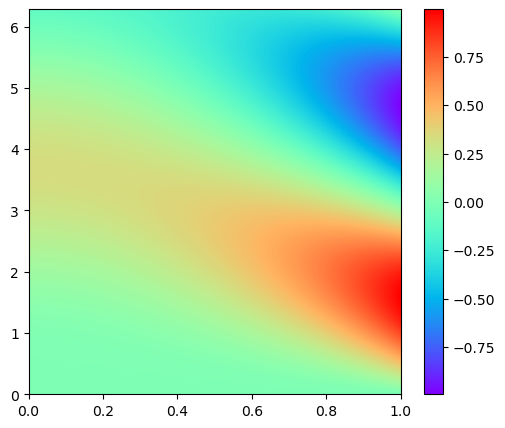

In [6]:
NNdata = DataPreprocessor(numSol, frac, extent, N_f)

**Setup the NN, train and save the weights**

In [7]:
# class PINN():
#     def __init__(self, data, layers, diffusivity):

#         ## gather train data ##
#             ## Initial Condition ##
#         self.xtrain_ic = torch.tensor(data.traindata['ic']['inp'][:, 0:1], requires_grad=True).float().to(device)
#         self.ttrain_ic = torch.tensor(data.traindata['ic']['inp'][:, 1:2], requires_grad=True).float().to(device)
#         self.utrain_ic = torch.tensor(data.traindata['ic']['out']).float().to(device)        
#             ## Boundary Condition Left ##
#         self.xtrain_bcl = torch.tensor(data.traindata['bcl']['inp'][:, 0:1], requires_grad=True).float().to(device)
#         self.ttrain_bcl = torch.tensor(data.traindata['bcl']['inp'][:, 1:2], requires_grad=True).float().to(device)
#         self.utrain_bcl = torch.tensor(data.traindata['bcl']['out']).float().to(device)   
#             ## Boundary Condition Right ##
#         self.xtrain_bcr = torch.tensor(data.traindata['bcr']['inp'][:, 0:1], requires_grad=True).float().to(device)
#         self.ttrain_bcr = torch.tensor(data.traindata['bcr']['inp'][:, 1:2], requires_grad=True).float().to(device)
#         self.utrain_bcr = torch.tensor(data.traindata['bcr']['out']).float().to(device)   
#             ## Domain data ##
#         self.xtrain_dom = torch.tensor(data.traindata['dom']['inp'][:, 0:1], requires_grad=True).float().to(device)
#         self.ttrain_dom = torch.tensor(data.traindata['dom']['inp'][:, 1:2], requires_grad=True).float().to(device)
#         self.utrain_dom = torch.tensor(data.traindata['dom']['out']).float().to(device)           
#             ## PDE loss collocation points ##
#         self.xtrain_pde = torch.tensor(data.traindata['pde']['inp'][:, 0:1], requires_grad=True).float().to(device)
#         self.ttrain_pde = torch.tensor(data.traindata['pde']['inp'][:, 1:2], requires_grad=True).float().to(device)

#         ## gather test data

#         self.xtest = torch.tensor(data.ground_truth['inp'][:, 0:1], requires_grad=True).float().to(device)
#         self.ttest = torch.tensor(data.ground_truth['inp'][:, 1:2], requires_grad=True).float().to(device)
#         self.utest = torch.tensor(data.ground_truth['out']).float().to(device)

#         ## Assign layers
#         self.layers = layers
        
#         ## diffusivity ##
#         self.diffusivity = diffusivity

#         # deep neural networks
#         self.dnn = DNN(layers).to(device)

#         # optimizers: using the same settings
#         self.optimizer = torch.optim.LBFGS(self.dnn.parameters(),
#                                            lr=.1,
#                                            max_iter=50000,
#                                            max_eval=50000,
#                                            history_size=50,
#                                            tolerance_grad=1e-8,
#                                            tolerance_change=1.0 * np.finfo(float).eps,
#                                            line_search_fn="strong_wolfe")
# #         self.optimizer = torch.optim.Adam(self.dnn.parameters())

#         self.iter = 0
#         self.losses = {'train': [],
#                        'train_ic': [],
#                        'train_bcl': [],
#                        'train_bcr': [],
#                        'train_dom': [],
#                        'train_pde': [],                       
#                        'test': [],
#                        'iter': []}

#     def net_u(self, x, t):
#         u = self.dnn(torch.cat([x, t], dim=1))
#         return u
    
#     def net_dudx(self, x, t):
        
#         u = self.net_u(x, t)
#         dudx = torch.autograd.grad(u, x, 
#                                    grad_outputs=torch.ones_like(u),
#                                    retain_graph=True,
#                                    create_graph=True)[0]
#         return dudx
    
#     def net_f(self, x, t):
#         """ The pytorch autograd version of calculating residual """
#         u = self.net_u(x, t)
        
#         dudt = torch.autograd.grad(u, t,
#                                    grad_outputs=torch.ones_like(u),
#                                    retain_graph=True,
#                                    create_graph=True)[0]        
#         dudx = torch.autograd.grad(u, x,
#                                    grad_outputs=torch.ones_like(u),
#                                    retain_graph=True,
#                                    create_graph=True)[0]
#         ddudxx = torch.autograd.grad(dudx, x, 
#                                      grad_outputs=torch.ones_like(dudx),
#                                      retain_graph=True,
#                                      create_graph=True)[0]
#         f = dudt - self.diffusivity * ddudxx
#         return f
    
#     def loss_func(self):

#         self.optimizer.zero_grad()

#         ## Training Losses ##
#             ## Initial condition ##
#         uhat_ic = self.net_u(self.xtrain_ic, self.ttrain_ic)
#         loss_ic = torch.mean((self.utrain_ic - uhat_ic) ** 2)
#             ## Boundary condition left ##
#         dudxhat_bcl = self.net_dudx(self.xtrain_bcl, self.ttrain_bcl)
#         loss_bcl = torch.mean((dudxhat_bcl) ** 2)
#             ## Boundary condition right ##
#         uhat_bcr = self.net_u(self.xtrain_bcr, self.ttrain_bcr)
#         loss_bcr = torch.mean((self.utrain_bcr - uhat_bcr) ** 2)        
#             ## Data on the domain ##
#         uhat_dom = self.net_u(self.xtrain_dom, self.ttrain_dom)
#         loss_dom = torch.mean((self.utrain_dom - uhat_dom) ** 2)
#             ## PDE loss on the collocation points ##
#         pde_val = self.net_f(self.xtrain_pde, self.ttrain_pde)
#         loss_pde = torch.mean(pde_val ** 2)
#             ## Final loss ##
#         loss_train = loss_ic + loss_bcl + loss_bcr + loss_dom + loss_pde
        
#         ## Test Loss ##
#         uhat_test = self.net_u(self.xtest, self.ttest)
#         loss_test = torch.mean((self.utest - uhat_test) ** 2)


#         loss_train.backward()
#         self.iter += 1
#         if self.iter % 100 == 0:
#             self.losses['train'].append(loss_train.item())
#             self.losses['train_ic'].append(loss_ic.item())
#             self.losses['train_bcl'].append(loss_bcl.item())
#             self.losses['train_bcr'].append(loss_bcr.item())
#             self.losses['train_dom'].append(loss_dom.item())
#             self.losses['train_pde'].append(loss_pde.item())
#             self.losses['test'].append(loss_test.item())
#             self.losses['iter'].append(self.iter)
#             print(
#                 'Iter %d, Loss train: %.5e, Loss test: %.5e' % (self.iter, loss_train.item(), loss_test.item())
#             )
#         return loss_train

#     def train(self):
#         self.dnn.train()

#         # Backward and optimize
#         self.optimizer.step(self.loss_func)

#         ## Plot the losses
#         fig, ax = plt.subplots(figsize=(6,5))
#         ax.plot(self.losses['iter'], self.losses['train'], label='train')
# #         ax.plot(self.losses['iter'], self.losses['train_ic'], label='IC')        
# #         ax.plot(self.losses['iter'], self.losses['train_bcl'], label='BC left')  
# #         ax.plot(self.losses['iter'], self.losses['train_bcr'], label='BC right')  
# #         ax.plot(self.losses['iter'], self.losses['train_dom'], label='Data')
# #         ax.plot(self.losses['iter'], self.losses['train_pde'], label='pde')
#         ax.plot(self.losses['iter'], self.losses['test'], label='test')
#         ax.set_yscale('log')
#         ax.set_xlabel('iterations')
#         ax.set_ylabel('loss')
#         ax.legend()
#         plt.savefig('results/losses.png')

#     def predict(self, data, xlocs, extent):

#         ## Get the evaluation on the domain
#         self.dnn.eval()
#         upred = self.net_u(self.xtest, self.ttest)
#         upred = upred.detach().cpu().numpy()
        
#         ## Extract the x and t data to convert into grid data
#         X, T = np.meshgrid(data.sol['x'], data.sol['t'])

#         ## Get the grid evaluation of prediction
#         Upred = griddata(data.ground_truth['inp'],
#                          upred.flatten(),
#                          (X, T), method='cubic')
        
#         ## Get the ground data on the domain
#         Utrue = data.sol['u']
        
#         ## Evaluate error on the domain
#         error = np.abs(Upred - Utrue)
        
#         ## Plot the ground truth, predictions and error ##
#         fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows=1, figsize=(18, 5))
#             ## Ground Truth ##
#         im1 = ax1.imshow(Utrue, origin='lower', aspect='auto',
#                         extent=np.asarray(extent).flatten(), vmin=Utrue.min(),
#                         vmax=Utrue.max(), interpolation='bilinear', cmap='rainbow')
#         clb1 = fig.colorbar(im1, ax=ax1, location='right')
#         clb1.ax.set_title('T')
#         ax1.set_title('Actual', fontsize=12)
#         ax1.set_xlabel('x')
#         ax1.set_ylabel('t')
#             ## Prediction ##
#         im2 = ax2.imshow(Upred, origin='lower', aspect='auto',
#                          extent=np.asarray(extent).flatten(), vmin=Utrue.min(),
#                          vmax=Utrue.max(), interpolation='bilinear', cmap='rainbow')
#         clb2 = fig.colorbar(im2, ax=ax2, location='right')
#         clb2.ax.set_title('T')
#         ax2.set_title('Prediction', fontsize=12)
#         ax2.set_xlabel('x')
#         ax2.set_ylabel('t')
#             ## Error ##
#         im3 = ax3.imshow(error, origin='lower', aspect='auto',
#                          extent=np.asarray(extent).flatten(),
#                          interpolation='bilinear', cmap='rainbow')
#         clb3 = fig.colorbar(im3, ax=ax3, location='right')        
#         clb3.ax.set_title('T')
#         ax3.set_title(r'Error = $|Actual - Prediction|$', fontsize=12)
#         ax2.set_xlabel('x')
#         ax2.set_ylabel('t')                
#             ## Save the plot
#         plt.savefig('results/contours.png')
        
#         ## Show the location of certain slices ##
#         fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows=1, figsize=(18, 5))
#             ## Generate the contour
#         im = ax1.imshow(Utrue, origin='lower', aspect='auto',
#                         extent=np.asarray(extent).flatten(), vmin=Utrue.min(),
#                         vmax=Utrue.max(), interpolation='bilinear', cmap='rainbow')
#         clb = fig.colorbar(im, ax=ax1, location='right')
#         clb.ax.set_title('T')
#         ax1.set_xlabel('x')
#         ax1.set_ylabel('t')
#         ax1.set_title('Actual, test/train split and slices', fontsize=12)
#             ## Generate and plot the lines
#         line = np.linspace(data.sol['t'].min(), data.sol['t'].max(), 2).reshape(-1,1)
#         nx = data.sol['x'].shape[0]
#         colors = plt.cm.brg(np.linspace(0,1,len(xlocs)))
#         for i, xloc in enumerate(xlocs):
#             ax1.plot(data.sol['x'][int(xloc*nx)]*np.ones((2,1)), line, 
#                      linestyle='--',linewidth=1,color=colors[i], clip_on=False)
#             ## Show the output variable along certain slices ##
#         for i, xloc in enumerate(xlocs):
#             ax2.plot(data.sol['t'], Utrue[:,int(xloc*nx)], c=colors[i], linewidth=2, alpha=0.7)
#             ax2.plot(data.sol['t'], Upred[:,int(xloc*nx)], c=colors[i], linestyle='--', linewidth=2)        
#         lines=ax2.get_lines()
#         legend = Legend(ax2, lines[:2*len(xlocs):2], ['x='+str(xloc) for xloc in xlocs])
#         ax2.add_artist(legend)
#         ax2.set_title('solution along slices',fontsize=12)        
#             ## Show the error in result along slices
#         for i, xloc in enumerate(xlocs):
#             ax3.plot(data.sol['t'], np.abs(Utrue[:,int(xloc*nx)] - Upred[:,int(xloc*nx)]), c=colors[i], linewidth=2)
#         lines=ax3.get_lines()
#         legend = Legend(ax3, lines, ['x='+str(xloc) for xloc in xlocs])
#         ax3.add_artist(legend)
#         ax3.set_title('error along slices',fontsize=12)
#             ## Save the plot
#         plt.savefig('results/slices.png')

Iter 100, Loss train: 1.90370e-01, Loss test: 3.89576e-02
Iter 200, Loss train: 7.61686e-02, Loss test: 8.61709e-03
Iter 300, Loss train: 3.36798e-02, Loss test: 2.13884e-03
Iter 400, Loss train: 2.02769e-02, Loss test: 1.26795e-03
Iter 500, Loss train: 1.08188e-02, Loss test: 8.39247e-04
Iter 600, Loss train: 6.95134e-03, Loss test: 6.33599e-04
Iter 700, Loss train: 4.59625e-03, Loss test: 2.99826e-04
Iter 800, Loss train: 3.01395e-03, Loss test: 1.73894e-04
Iter 900, Loss train: 1.90651e-03, Loss test: 1.37001e-04
Iter 1000, Loss train: 1.37388e-03, Loss test: 7.65092e-05
Iter 1100, Loss train: 1.04622e-03, Loss test: 5.85697e-05
Iter 1200, Loss train: 7.40079e-04, Loss test: 3.06626e-05
Iter 1300, Loss train: 6.45543e-04, Loss test: 2.57728e-05
Iter 1400, Loss train: 5.64415e-04, Loss test: 2.80784e-05
Iter 1500, Loss train: 5.46663e-04, Loss test: 2.76459e-05
Iter 1600, Loss train: 5.04509e-04, Loss test: 2.62517e-05
Iter 1700, Loss train: 4.57690e-04, Loss test: 1.84246e-05
Iter 1

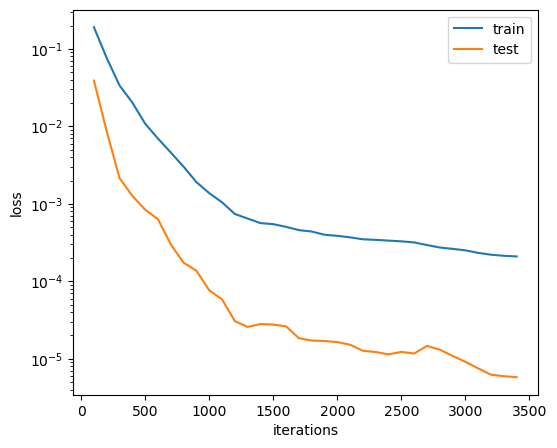

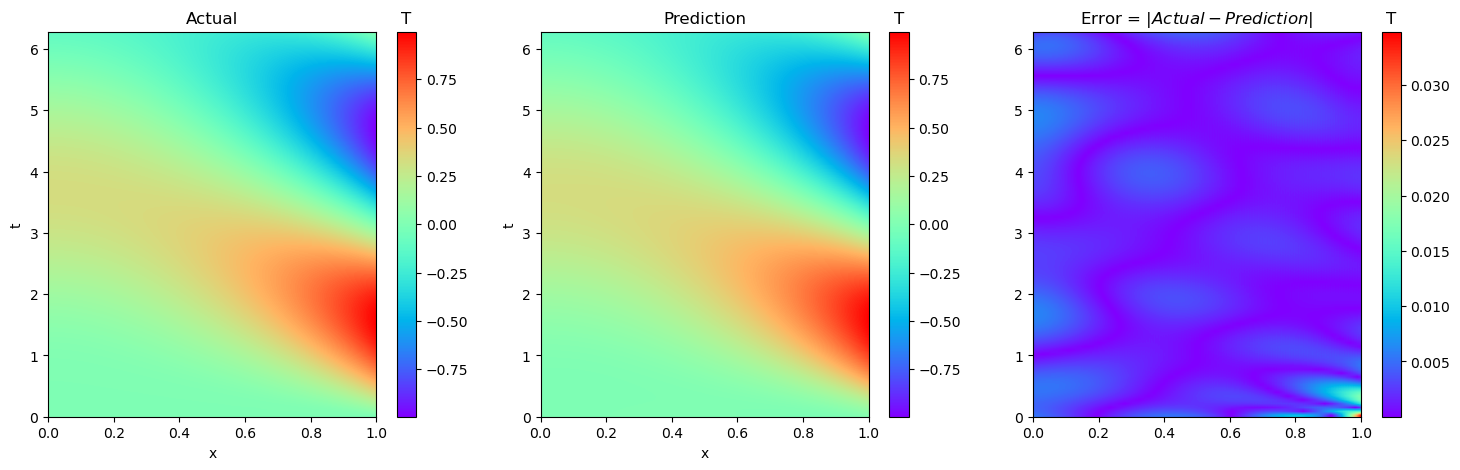

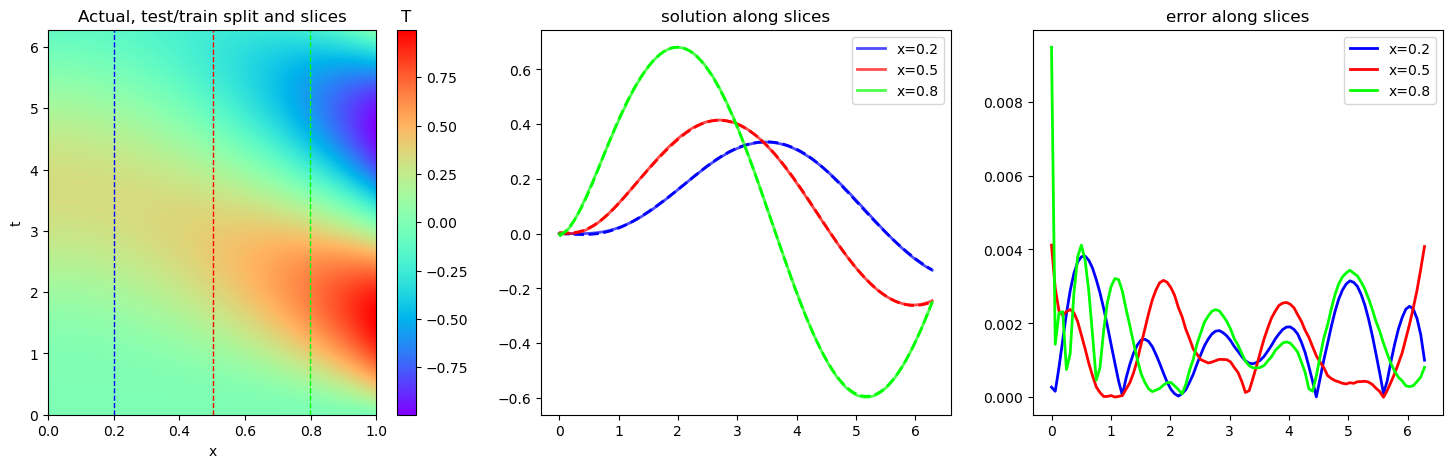

In [8]:
model = PINN(NNdata, layers, diffusivity)
if os.path.isfile('saved/trained_parameters'):
    model.dnn.load_state_dict(torch.load('saved/trained_parameters', map_location=torch.device('cpu')))
else:
    model.train()
    torch.save(model.dnn.state_dict(), 'saved/trained_parameters')

**Run the predictions**

In [ ]:
model.predict(NNdata, [0.2, 0.50, 0.8], extent)